In [5]:
from imports import *
from preprocessing_util import get_column_groups, get_transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.preprocessing import OneHotEncoder

In [6]:
query = "select * from train_data"
train_data = sql_connect(query)
X_train = train_data.drop(columns=['TARGET'])
y_train = train_data['TARGET']
del train_data
X_train.head()

Connection to SQL Server established successfully.
Connection closed.


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AVERAGE_EXTERNAL_RATING,TOT_PREV_APP,PREV_APPROVED_CNT,PREV_CANCELLED_CNT,PREV_REFUSED_CNT,PREV_UNUSED_CNT,ISMISSING_BUREAU_INFO,ADDITIONAL_DOC_PROVIDED,NOT_EMPLOYED_FLAG,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,INCOME_PER_MEM
0,Cash loans,F,0,0,0,76500.0,1078200.0,38200.5,900000.0,Working,Secondary / secondary special,Married,House / apartment,0.026392,-1,1,1,0,1,0,0,Core staff,2,2,0,0,0,0,1,1,Kindergarten,5,0,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.6783,0,0,0,0,0,1,True,0,28.26,5.11,13.18,1.10,1.96,38250.0
1,Revolving loans,F,0,1,0,112500.0,225000.0,11250.0,225000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.035792,-1,1,1,0,1,0,0,Sales staff,2,2,0,0,0,0,0,0,Trade: type 7,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.5881,1,0,0,1,0,0,False,0,49.48,1.28,15.24,4.38,3.00,112500.0
2,Revolving loans,F,0,1,0,112500.0,270000.0,13500.0,270000.0,Working,Secondary / secondary special,Married,House / apartment,0.020713,-1,1,1,0,1,0,0,Laborers,3,2,0,0,0,0,0,0,Government,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.5163,0,0,0,0,0,0,False,0,36.73,2.30,19.68,12.50,1.39,56250.0
3,Cash loans,F,0,0,0,157500.0,521280.0,26743.5,450000.0,Working,Higher education,Married,House / apartment,0.031329,-1,1,1,1,1,1,0,Security staff,2,2,0,0,0,0,0,0,Government,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.4890,0,0,0,0,0,0,True,0,31.73,9.95,14.46,3.55,3.09,78750.0
4,Cash loans,M,1,1,0,90000.0,74628.0,7834.5,67500.0,Working,Secondary / secondary special,Married,House / apartment,0.031329,13,1,1,1,1,1,0,Laborers,2,2,0,0,0,0,1,1,Construction,6,0,6,0,0.0,0.0,0.0,1.0,0.0,2.0,0.4858,1,1,0,0,0,0,True,0,55.12,5.00,17.09,10.07,1.17,45000.0


In [7]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
categorical_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE']

In [ ]:
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

In [33]:
scoring = {
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

In [36]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

scores = cross_validate(pipeline, X_train, y_train, cv=cv_strategy, scoring=scoring)

print("Baseline Random Forest - Cross-Validation Metrics:")
for metric in scoring:
    print(f"{metric.upper():<8}: {np.mean(scores[f'test_{metric}']):.3f}")



Baseline Random Forest - Cross-Validation Metrics:
RECALL  : 0.918
PRECISION: 0.860
F1      : 0.880


But we need to PR curve too

In [42]:
y_train_prob[:, 1]

array([0.02, 0.  , 0.  , ..., 0.07, 0.02, 0.05], shape=(33494,))

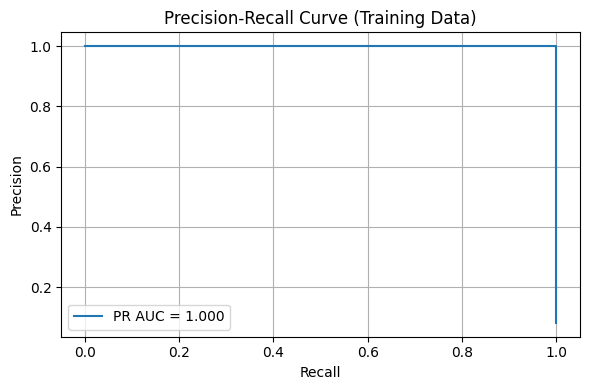

In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score

pipeline.fit(X_train, y_train)

y_train_prob = pipeline.predict_proba(X_train)

precision, recall, thresholds  = precision_recall_curve(y_train, y_train_prob[:, 1])

pr_auc = average_precision_score(y_train, y_train_prob[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Training Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()